# **Deep Convolutional Generative Adversarial Network (DC-GAN):**



DC-GAN is a foundational adversarial framework developed in 2015. 

It had a major contribution in streamlining the process of designing adversarial frameworks and visualizing intermediate representations, thus, making GANs more accessible to both researchers and practitioners. This was achieved by enhancing the concept of adversarial training (introduced by [Ian Goodfellow](https://arxiv.org/abs/1406.2661) one year prior) with then-state-of-the-art advances in deep learning such as strided and fractional-strided convolutions, batch normalization and LeakyReLU activations.

In this programming exercise, you are tasking with creating a miniature [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DC-GAN) framework for the generation of MNIST digits. The goal is to bridge the gap between the theoretical concept and the practical implementation of GANs. 

![A diagram of a generator and discriminator](https://www.cntk.ai/jup/GAN_basic_flow.png)

The desired DC-GAN network should consist of two principal components: the generator $G$ and the discriminator $D$. The generator should receive as input a 100-dimensional random noise vector $z$ and outputs a synthetically generated MNIST digit $G(z)$ of pixel size $28 \times 28 \times 1$. As the adversarial training continues over time, the output digits should increasingly resemble handwritten digits as shown below.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

The discriminator network receives both the synthetically generated digits as well as ground-truth MNIST digits $x$ as inputs. $D$ is trained as a binary classifier. In other words, it is trained to assign the correct label (real vs fake) to both sets of input images. On the other hand side, $G$ is motivated to fool the discriminator into making a false decision by implicitly improving the quality of the output synthetic image. This adversarial training procedure, where both networks are trained with opposing goals, is represented by the following min-max optimization task:

>$\underset{G}{\min} \underset{D}{\max} \mathcal{L}_{\textrm{adv}} =\underset{G}{\min} \underset{D}{\max} \; \mathbb{E}_{x} \left[\textrm{log} D(x) \right] + \mathbb{E}_{z} \left[\textrm{log} \left( 1 - D\left(G(z)\right) \right) \right]$

# Implementation



### Import Import TensorFlow and other libraries





In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__


'2.2.0'

In [ ]:
# To generate GIFs for illustration
!pip install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

You can also repeat the exercise for other avaliable variations of the MNIST dataset such as: EMNIST, Fashio-MNIST or KMNIST. For more details, please refer to [tensorflow_datasets](https://www.tensorflow.org/datasets/datasets).


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
print(train_images.shape)

(60000, 28, 28)


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5# Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (fractional-strided convolutional) layers to produce an image from an input noise vector. Start with a fully connected layer that takes this vector as input, then upsample several times until you reach the desired image size of $28\times 28 \times 1$. Utilize the `tf.keras.layers.LeakyReLU` activation and batch normalization for each intermediate layer, except the output layer which should use tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Fully connected layer: model.add(layers.Dense(#*#*#, use_bias=False, input_shape=(100,)))  
    # Batch norm
    # Activation function
    # Reshape
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    # Layer 2: Hint use layers.Conv2DTranspose with 5x5 kernels and appropriate stride
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    # Layer 3
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)

    #Layer4
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)


    return model

Use the (as yet untrained) generator to create an image.

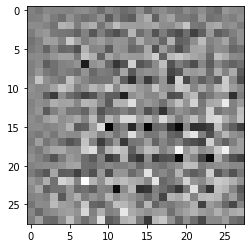

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Layer 1: use layers.Conv2D with 5x5 kernels and appropriate stride
    # Activation function
    # Dropout
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Layer 2: Conv2D
    # Activation function
    # Dropout
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    # Layer 3: Fully connected layer, output dimension must be 1
    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00013186]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute the binary cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Define the discriminator loss function. [Hint](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy): compare the discriminator's predictions on real images to an array of 1s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Again, use the same principle used to define the real_loss to define the generator_loss.

In [ ]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return generator_loss

The discriminator and the generator optimizers are different since both networks are trained separately. Hint: use Adam optimizers. Experiment with the learning rates.

In [ ]:
#learning rate of 1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted (especially for larger datasets).

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop should begin with generator receiving a random vector as input. That vector will be used to produce an image. The discriminator should then be used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss will be calculated for each of these models, and the gradients used to update the generator and discriminator

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise_vector = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
      generated_images = generator(noise_vector, training=True)
      
      # Discriminator output
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      # Loss functions
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
  
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             noise_vector)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           noise_vector)

**Generate and save images**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

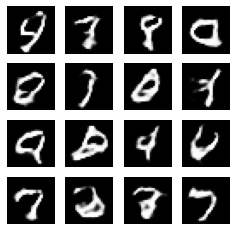

CPU times: user 1min 49s, sys: 14.8 s, total: 2min 4s
Wall time: 5min 16s


In [ ]:
%%time
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

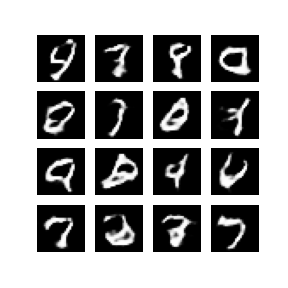

In [ ]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 8*(i**0.25)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Next Steps

How does the generated digits compare with the original MNIST? Optimize the network design and training hyperparameters further for better results.

Repeat the above steps for other similar datasets such as Fashion-MNIST or expand the capacities of the network appropriately to suit larger datasets such as the Large-scale Celeb Faces Attributes (CelebA) dataset. 